In [ ]:
#@title foo
#!pip install transformers==4.1.1 plotnine

## setting stuff up

In [1]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import seaborn
import plotnine
from plotnine import *

from ahviz import create_indices, create_dataframe, filter_mask
import torch
from transformers import AutoModel, AutoTokenizer

plotnine.options.figure_size = (20, 20)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
# uncomment to force CPU if you have a GPU but not enough memory to do what you want. it will be slow of course

device = torch.device("cpu")

In [3]:
#transformer = "distilbert-base-cased"
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


## data preparation

In [4]:
# read the prepared data.
# based on the penn treebank sample in nltk; prepared with the convert_corpus.py script
sentences = pd.read_csv("lines.csv")
sentences['length'] = sentences.line.str.split().apply(len)
display(sentences[sentences['length'] <100].length.describe())

count    3913.000000
mean       20.652952
std         9.943947
min         1.000000
25%        13.000000
50%        20.000000
75%        27.000000
max        80.000000
Name: length, dtype: float64

In [5]:
concatenated = " ".join(sentences['line'].tolist()[:20])
window_size = 25
step = 5
future = 10
tokens = torch.tensor(tokenizer(concatenated)['input_ids'])
tokens.shape

Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


torch.Size([568])

In [6]:
pad_len = window_size - len(tokens) % window_size
padded = torch.cat((tokens, tokens.new_full((pad_len,), tokenizer.pad_token_id)))
mask = torch.cat((torch.zeros(window_size - (step + future)), torch.ones(step), torch.zeros(future))).expand((100,-1))[0]

print(mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])


In [7]:
def get_batches(input_tensor:torch.Tensor, size: int, step: int, batch_size :int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    attention_mask = torch.cat((torch.zeros(window_size - step), torch.ones(step))).expand((input_ids.size(0),-1))
    tensor_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    
    return tensor_dataloader

In [8]:
dl = get_batches(padded, window_size, step, batch_size=100)

In [20]:
data = None
for batch, t in enumerate(dl):
    input_dict = {k: v.to(device) for k, v in zip(["input_ids"], t)}
    
    output = model(**input_dict)

    att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
    
    # swap the 'head' and 'sampple' axes so we can more easily apply the attention mask
    att = np.swapaxes(att, 1, 2)
#    print(batch, att.shape)
    ix = create_indices(att, sample=batch*att.shape[2])
    df = create_dataframe(att, ix)
#    print(df.shape)
    filtered = df[(df['from_token']>(window_size-(step+future))) & (df['from_token']<=(window_size-future)) ]
    filtered = filtered[filtered['attention_fraction'] > 0]
#    print(df.shape)

    if data is None:
        data = filtered
    else:
        data = pd.concat([data, filtered])
    print(batch, df.shape, filtered.shape, data.shape)


0 (9000000, 6) (1800000, 6) (1800000, 6)
1 (990000, 6) (198000, 6) (1998000, 6)


## getting the data ready to plot

In [21]:
df = data.reset_index(drop=True)

### calculate the weighted distances and their median per head

In [22]:
df['distance'] = (df['to_token'] - df['from_token'])
df['sign'] = df['distance'] > 0

In [23]:
display(df)

,to_token,from_token,sample,head,layer,attention_fraction,distance,sign
0,1,11,1,1,1,0.164418,-10,False
1,2,11,1,1,1,0.021302,-9,False
2,3,11,1,1,1,0.044567,-8,False
3,4,11,1,1,1,0.032044,-7,False
4,5,11,1,1,1,0.000692,-6,False
...,...,...,...,...,...,...,...,...
1997995,21,15,22,12,12,0.005048,6,True
1997996,22,15,22,12,12,0.004626,7,True
1997997,23,15,22,12,12,0.003608,8,True
1997998,24,15,22,12,12,0.004934,9,True


In [24]:
# show the data for the second token of the first sentence for the first layer and the first head
# which is really the first one in the data as I filter out [CLS] above
with pd.option_context("max_rows", None):
    display(df.query("layer == 1 & head == 1 & sample == 1 & from_token == 11").sort_values("attention_fraction", ascending=False))

,to_token,from_token,sample,head,layer,attention_fraction,distance,sign
0,1,11,1,1,1,0.164418,-10,False
15,16,11,1,1,1,0.088448,5,True
20,21,11,1,1,1,0.073245,10,True
22,23,11,1,1,1,0.062862,12,True
14,15,11,1,1,1,0.052539,4,True
17,18,11,1,1,1,0.050357,7,True
16,17,11,1,1,1,0.049534,6,True
2,3,11,1,1,1,0.044567,-8,False
19,20,11,1,1,1,0.038711,9,True
5,6,11,1,1,1,0.037374,-5,False


In [71]:
df = df.sort_values(['layer', 'head', 'sample', 'from_token', 'attention_fraction'], ascending=[True, True, True, True, False])
sg = df.groupby(['layer', 'head', 'sample', 'from_token'])

In [72]:
df['cumulative_attention'] = sg['attention_fraction'].cumsum()

In [73]:
df['shifted'] = df['cumulative_attention'].shift(-1).fillna(1)

In [74]:
df = df[df['shifted'] < 0.9]

In [75]:
display(df)

,to_token,from_token,sample,head,layer,attention_fraction,distance,sign,weighted,cumulative_attention,shifted
0,1,11,1,1,1,0.164418,-10,False,-1.644183,0.164418,0.252866
15,16,11,1,1,1,0.088448,5,True,0.442239,0.252866,0.326111
20,21,11,1,1,1,0.073245,10,True,0.732452,0.326111,0.388973
22,23,11,1,1,1,0.062862,12,True,0.754339,0.388973,0.441512
14,15,11,1,1,1,0.052539,4,True,0.210157,0.441512,0.491869
...,...,...,...,...,...,...,...,...,...,...,...
1799935,11,13,100,12,12,0.370255,-2,False,-0.740511,0.794361,0.794447
1799941,17,13,100,12,12,0.000086,4,True,0.000344,0.794447,0.613831
1799963,14,14,100,12,12,0.613831,0,False,0.000000,0.613831,0.827908
1799960,11,14,100,12,12,0.214077,-3,False,-0.642232,0.827908,0.827931


In [84]:
df = df.merge(sg['cumulative_attention'].max().reset_index().rename(columns={'cumulative_attention': 'total'}), on=['layer', 'head', 'sample', 'from_token'])

In [85]:
display(df)

,to_token,from_token,sample,head,layer,attention_fraction,distance,sign,weighted,cumulative_attention,shifted,total
0,1,11,1,1,1,0.164418,-10,False,-1.644183,0.164418,0.252866,0.850589
1,16,11,1,1,1,0.088448,5,True,0.442239,0.252866,0.326111,0.850589
2,21,11,1,1,1,0.073245,10,True,0.732452,0.326111,0.388973,0.850589
3,23,11,1,1,1,0.062862,12,True,0.754339,0.388973,0.441512,0.850589
4,15,11,1,1,1,0.052539,4,True,0.210157,0.441512,0.491869,0.850589
...,...,...,...,...,...,...,...,...,...,...,...,...
600397,11,13,100,12,12,0.370255,-2,False,-0.740511,0.794361,0.794447,0.794447
600398,17,13,100,12,12,0.000086,4,True,0.000344,0.794447,0.613831,0.794447
600399,14,14,100,12,12,0.613831,0,False,0.000000,0.613831,0.827908,0.827931
600400,11,14,100,12,12,0.214077,-3,False,-0.642232,0.827908,0.827931,0.827931


In [86]:
df['adjusted'] = df['attention_fraction'] / df['total']

In [87]:
display(df)

,to_token,from_token,sample,head,layer,attention_fraction,distance,sign,weighted,cumulative_attention,shifted,total,adjusted
0,1,11,1,1,1,0.164418,-10,False,-1.644183,0.164418,0.252866,0.850589,0.193299
1,16,11,1,1,1,0.088448,5,True,0.442239,0.252866,0.326111,0.850589,0.103984
2,21,11,1,1,1,0.073245,10,True,0.732452,0.326111,0.388973,0.850589,0.086111
3,23,11,1,1,1,0.062862,12,True,0.754339,0.388973,0.441512,0.850589,0.073904
4,15,11,1,1,1,0.052539,4,True,0.210157,0.441512,0.491869,0.850589,0.061768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
600397,11,13,100,12,12,0.370255,-2,False,-0.740511,0.794361,0.794447,0.794447,0.466054
600398,17,13,100,12,12,0.000086,4,True,0.000344,0.794447,0.613831,0.794447,0.000108
600399,14,14,100,12,12,0.613831,0,False,0.000000,0.613831,0.827908,0.827931,0.741403
600400,11,14,100,12,12,0.214077,-3,False,-0.642232,0.827908,0.827931,0.827931,0.258569


In [89]:
df['weighted'] = df['distance'] * df['adjusted']

In [90]:
g = df.groupby(['layer', 'head', 'sign'])
median_dist = (g['weighted'].median()).reset_index().round(3)

In [91]:
display(median_dist)

,layer,head,sign,weighted
0,1,1,False,-0.283
1,1,1,True,0.328
2,1,2,False,-0.315
3,1,2,True,0.073
4,1,3,False,-0.179
...,...,...,...,...
281,12,10,True,0.297
282,12,11,False,-0.228
283,12,11,True,0.286
284,12,12,False,-0.075


## plot

Cheat a bit by limiting the plots to show only the interval between 0 and 2 for the weighted distance. 

This unsquishes the violins to reveal a pattern a bit similar to the plot of `k` in the Hopfields networks
paper, but it does hide values (especially for the dot plot), which may give a false impression

you can change the interval by adjusting the limits variable

/home/martijn/.virtualenvs/hug/lib/python3.9/site-packages/plotnine/stats/stat_density.py:151: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/martijn/.virtualenvs/hug/lib/python3.9/site-packages/plotnine/stats/stat_density.py:154: PlotnineWarning: Groups with fewer than 2 data points have been removed.


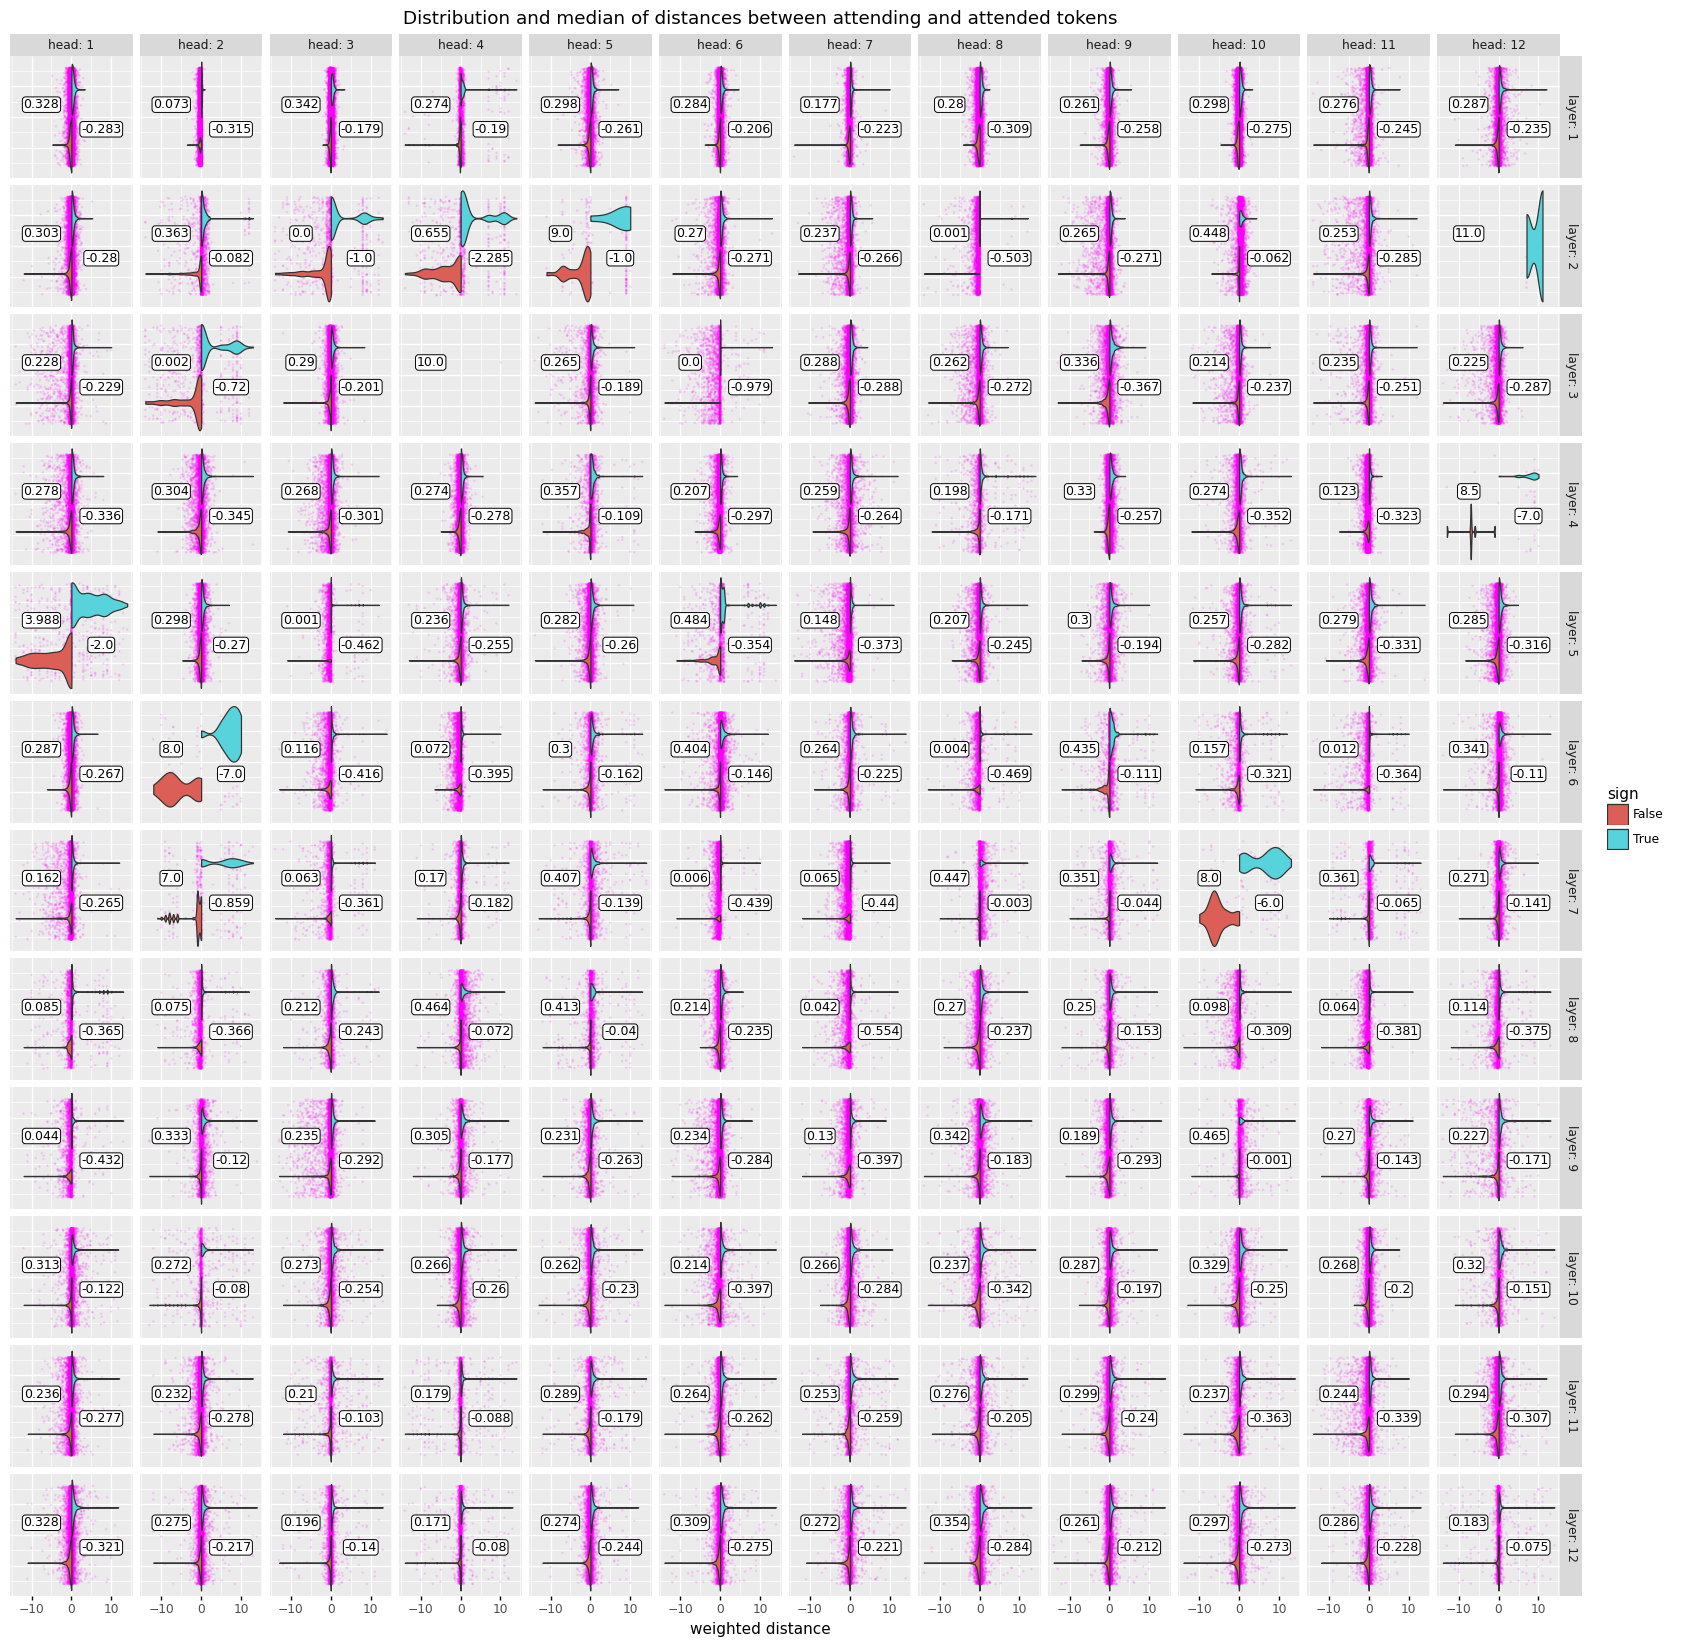

<ggplot: (8753830094821)>

In [99]:
# plot it!
limits = (-10, 10)
plotnine.options.figure_size = (20, 20)
(ggplot(df, aes(1, "weighted"))  + 
     geom_jitter(height=0, size=0.1, alpha=0.1, color="magenta") +
     geom_violin(mapping=aes(fill="sign")) +
     geom_label(data=median_dist[median_dist['sign'] == True], mapping=aes(x=1.1, y=limits[0] * .75, label="weighted"), label_padding=0.1, size=9) +
     geom_label(data=median_dist[median_dist['sign'] == False], mapping=aes(x=0.9, y=limits[1] * .75, label="weighted"), label_padding=0.1, size=9) +
     scale_y_continuous(breaks=np.linspace(*limits, num=3)) +
     facet_grid("layer ~ head", labeller="label_both") + 
     coord_flip(
#         ylim=limits
     ) +
     labs(
             x = "",
             y = "weighted distance",
             title = "Distribution and median of distances between attending and attended tokens"
         ) +
     theme(
             axis_text_y = element_blank(),
             axis_ticks_major_y = element_blank()
         )
)

### subset of heads

plot only a few heads, so each facet can be bigger and it's not as neccesary to limit what is shown

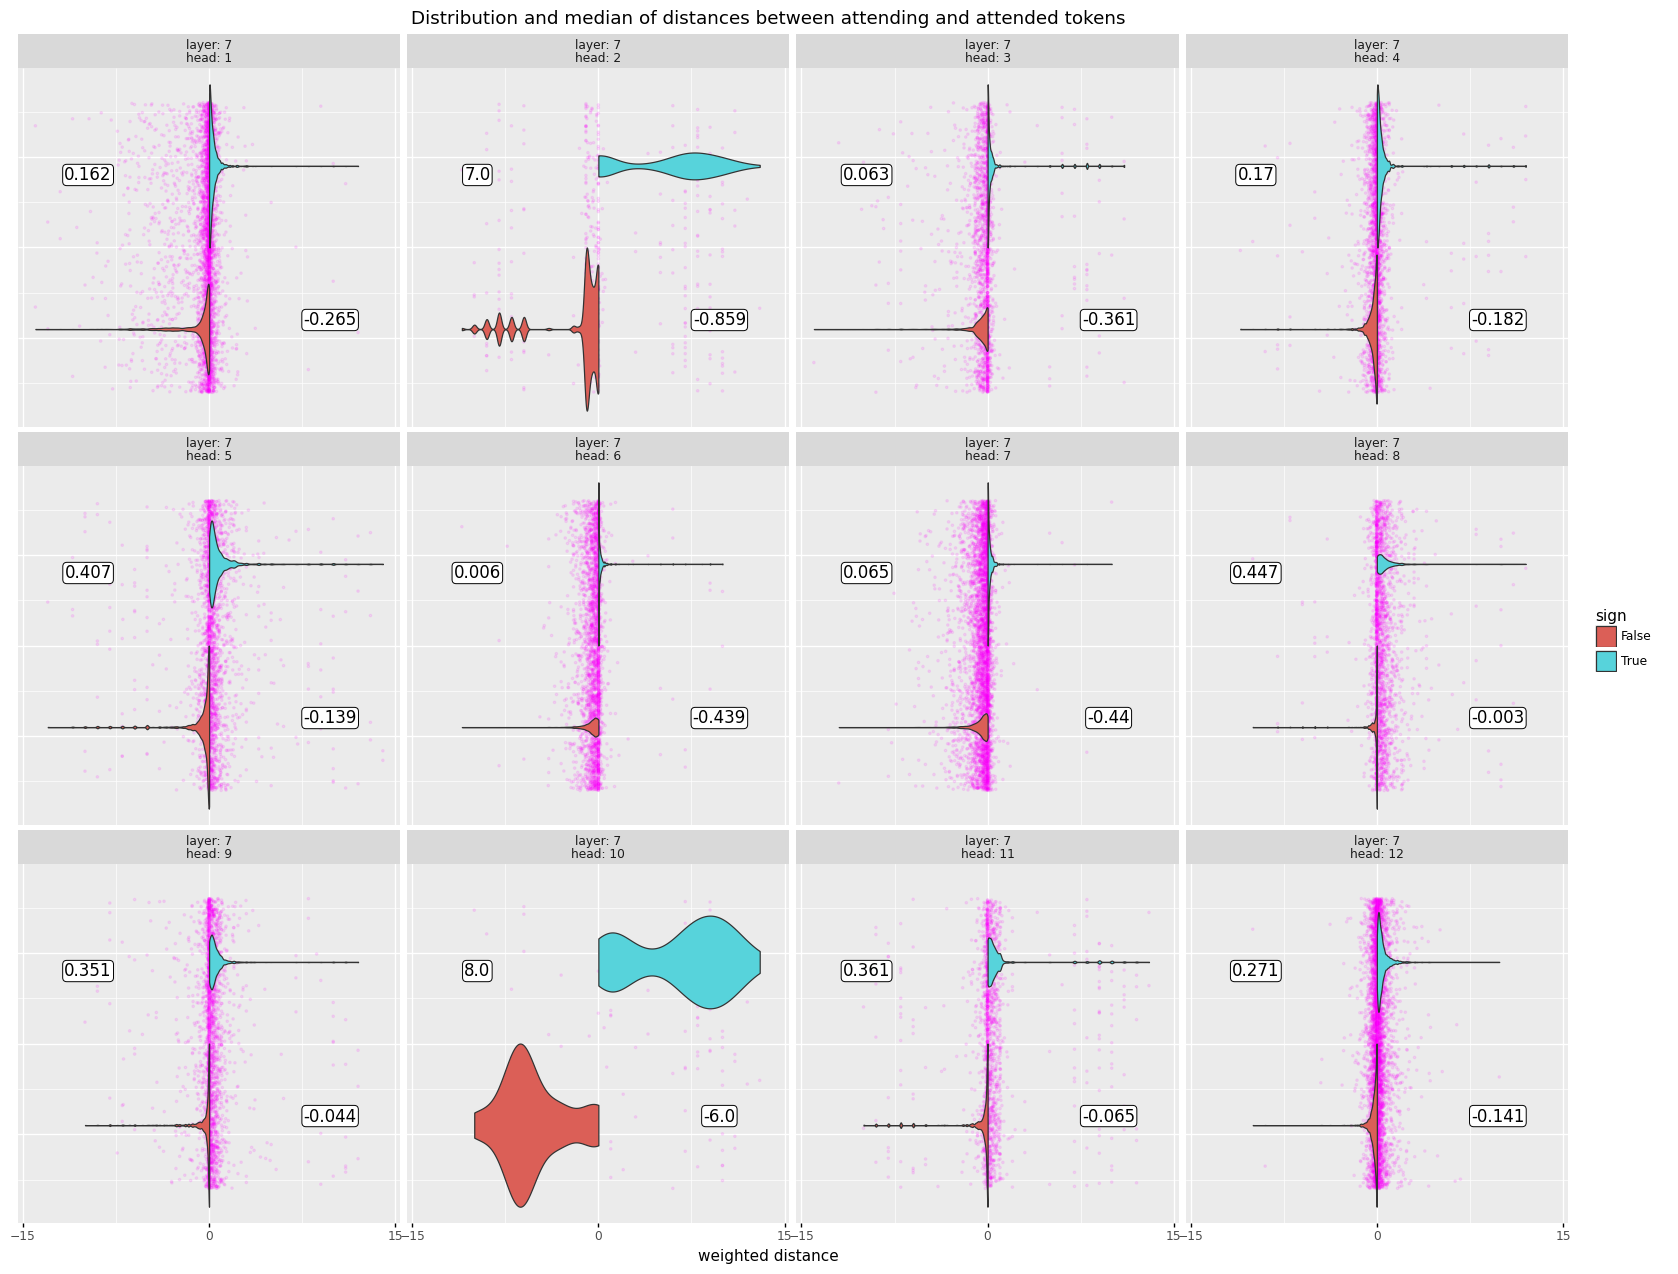

<ggplot: (8753831078557)>

In [98]:
#subset = "layer == 1 & head >= 3 & head <= 5"
subset = "layer == 7"
plotnine.options.figure_size = (20, 15)
limits=(-15,15)
(ggplot(df.query(subset), aes(1, "weighted"))  + 
     geom_jitter(height=0, size=0.5, alpha=0.1, color="magenta") +
     geom_violin(mapping=aes(fill="sign")) +
     geom_label(data=median_dist[median_dist['sign'] == True].query(subset), mapping=aes(x=1.2, y=limits[0] * .65, label="weighted"), label_padding=0.1, size=12) +
     geom_label(data=median_dist[median_dist['sign'] == False].query(subset), mapping=aes(x=0.8, y=limits[1] * .65, label="weighted"), label_padding=0.1, size=12) +
     scale_y_continuous(breaks=np.linspace(*limits, num=3)) +
     facet_wrap("~ layer + head", labeller="label_both") + 
     coord_flip(
#             ylim=limits
         ) +
     labs(
             x = "",
             y = "weighted distance",
             title = "Distribution and median of distances between attending and attended tokens"
         ) +
     theme(
             axis_text_y = element_blank(),
             axis_ticks_major_y = element_blank()
         )
)

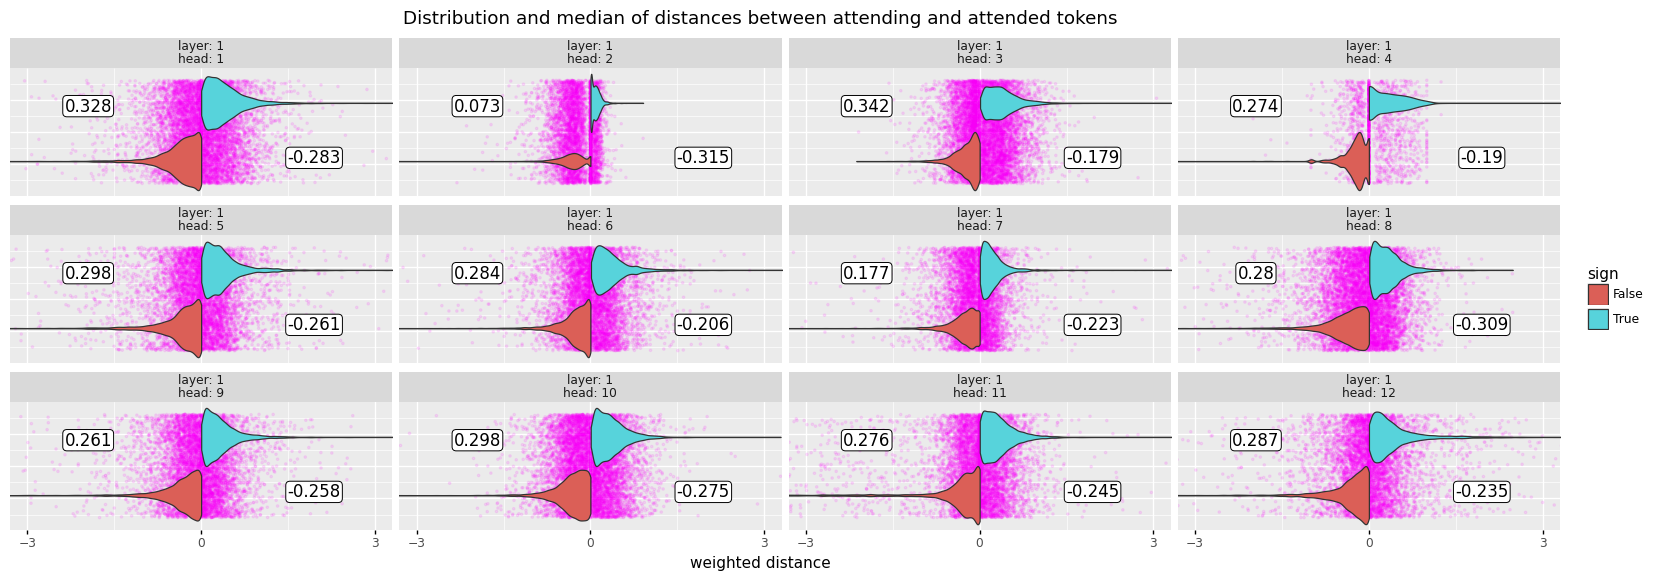

<ggplot: (8753748631721)>

In [93]:
#subset = "layer == 1 & head >= 3 & head <= 5"
subset = "layer == 1"
plotnine.options.figure_size = (20, 6)
limits=(-3,3)
(ggplot(df.query(subset), aes(1, "weighted"))  + 
     geom_jitter(height=0, size=0.5, alpha=0.1, color="magenta") +
     geom_violin(mapping=aes(fill="sign")) +
     geom_label(data=median_dist[median_dist['sign'] == True].query(subset), mapping=aes(x=1.2, y=limits[0] * .65, label="weighted"), label_padding=0.1, size=12) +
     geom_label(data=median_dist[median_dist['sign'] == False].query(subset), mapping=aes(x=0.8, y=limits[1] * .65, label="weighted"), label_padding=0.1, size=12) +
     scale_y_continuous(breaks=np.linspace(*limits, num=3)) +
     facet_wrap("~ layer + head", labeller="label_both") + 
     coord_flip(
             ylim=limits
         ) +
     labs(
             x = "",
             y = "weighted distance",
             title = "Distribution and median of distances between attending and attended tokens"
         ) +
     theme(
             axis_text_y = element_blank(),
             axis_ticks_major_y = element_blank()
         )
)